### Vorbereitung der Daten

In [ ]:
!gdown 1MJGlr_OaCtXyv0s25FCQFs2j2bhsQeXQ

In [ ]:
!unzip -q data.zip

In [ ]:
!gdown 1abJoLngmQcklgC67WRL1GUPJdS1-51Qb

In [ ]:
!unzip -q Yolov4.zip

In [ ]:
# Version 12
!pip install open3d 

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import glob
import open3d as o3d

#### Die Dateien laden

In [ ]:
image_files = sorted(glob.glob("data/video2/images/*.png"))
point_files = sorted(glob.glob("data/video2/points/*.pcd"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

index = 2
pcd_file = point_files[index]
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)
cloud = o3d.io.read_point_cloud(pcd_file)
points= np.asarray(cloud.points)

In [ ]:
index = 2
pcd_file = point_files[index]
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)
cloud = o3d.io.read_point_cloud(pcd_file)
points= np.asarray(cloud.points)

#### Das Bild visualisieren

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Image', fontsize=30)

#### Die Punktewolken visualisieren

In [ ]:
!pip install pypotree #https://github.com/centreborelli/pypotree

In [12]:
import pypotree
cloudpath = pypotree.generate_cloud_for_display(points)
pypotree.display_cloud_colab(cloudpath)

/usr/local/lib/python3.10/dist-packages/bin/PotreeConverter .tmp.txt -f xyz -o point_clouds -p 2e68a8 --material ELEVATION --edl-enabled --overwrite
server on port 43993: thread <Thread(Thread-11 (server_entry), started 135463306188352)> 
https://localhost:43993/point_clouds/pointclouds/2e68a8


#### 1 - Die Punkte im Bild projizieren <p>
Es soll versucht werden, die 3D-Punkte in das Bild zu projizieren:<p>

Das erfordert, dass die folgenden Schritte unternommen werden müssen.<p>

* Die Punkte auswählen, die im Bild **sichtbar** sind
* Die Punkte **vom LiDAR-Koordinatensystem ins Kamerakoordinatensystem umwandeln**
* Einen Weg finden, um **vom Kamerakoordinatensystem ins Bildkoordinatensystem zu projizieren**

#### 1.1 - Die Kalibrierungsdatei einlesen

Die Kalibrierungsdateien sollen zunächst eingelesen werden. Für jedes Bild existiert eine zugehörige Kalibrierungsdatei, die die folgenden Informationen angibt:<p>

* Die intrinsischen und extrinsischen Kamerakalibrierungsparameter
* Die Velodyne-zu-Kamera-Matrizen
* Alle anderen "Sensor A" zu "Sensor B" Matrizen
<p>
Diese stammen aus dieser Einrichtung:<p>

![link text](http://www.cvlibs.net/datasets/kitti/images/setup_top_view.png)

*    **Die Variable "Velo-To-Cam" wird als "V2C" bezeichnet werden** -- Sie gibt die Rotations- und Translationsmatrizen von der Velodyne-Kamera zur linken Graustufenkamera an.
*    **R0_rect wird in der Stereovision verwendet, um die Bilder coplanar zu machen.**
*   **P2 ist die Matrix, die nach der Kamerakalibrierung erhalten wird**. Sie enthält die intrinsische Matrix K und die extrinsische.

In [13]:
class LiDAR2Camera(object):
    def __init__(self, calib_file):
        calibs = self.read_calib_file(calib_file)
        P = calibs["P2"]
        self.P = np.reshape(P, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        V2C = calibs["Tr_velo_to_cam"]
        self.V2C = np.reshape(V2C, [3, 4])
        # Rotation from reference camera coord to rect camera coord
        R0 = calibs["R0_rect"]
        self.R0 = np.reshape(R0, [3, 3])

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data


In [14]:
lidar2cam = LiDAR2Camera(calib_files[index])
print("P :"+str(lidar2cam.P))
print("-")
print("RO "+str(lidar2cam.R0))
print("-")
print("Velo 2 Cam " +str(lidar2cam.V2C))
print("-")
#print("Cam 2 Velo" + str(lidar2cam.C2V))

P :[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
-
RO [[ 0.9999239   0.00983776 -0.00744505]
 [-0.0098698   0.9999421  -0.00427846]
 [ 0.00740253  0.00435161  0.9999631 ]]
-
Velo 2 Cam [[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]]
-


#### 1.2 - Die Punkte im Bild projizieren

Die Hauptformel, die verwendet werden wird, lautet wie folgt:<p>
Y(2D) = P x R0 x R|t x X (3D)

Allerdings, wenn die Dimensionen betrachtet werden:

* P: [3x4]
* R0: [3x3]
* R|t = Velo2Cam: [3x4]
* X: [3x1]

Es wird notwendig sein, einige Punkte in homogene Koordinaten umzuwandeln:
* RO muss von 3x3 auf 4x3 umgewandelt werden
* x muss von 3x1 auf 4x1 umgewandelt werden

In [15]:
def cart2hom(self, pts_3d):
    """ Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    """
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
    return pts_3d_hom

LiDAR2Camera.cart2hom = cart2hom

In [16]:
def project_velo_to_image(self, pts_3d_velo):
    '''
    Input: 3D points in Velodyne Frame [nx3]
    Output: 2D Pixels in Image Frame [nx2]
    '''
    # REVERSE TECHNIQUE
    '''
    homogeneous = self.cart2hom(pts_3d_velo)  # nx4
    dotted_RT = np.dot(homogeneous, np.transpose(self.V2C)) #nx3
    dotted_with_RO = np.transpose(np.dot(self.R0, np.transpose(dotted_RT))) #nx3
    homogeneous_2 = self.cart2hom(dotted_with_RO) #nx4
    pts_2d = np.dot(homogeneous_2, np.transpose(self.P))  # nx3
    '''

    # NORMAL TECHNIQUE
    R0_homo = np.vstack([self.R0, [0, 0, 0]])
    R0_homo_2 = np.column_stack([R0_homo, [0, 0, 0, 1]])
    p_r0 = np.dot(self.P, R0_homo_2) #PxR0
    p_r0_rt =  np.dot(p_r0, np.vstack((self.V2C, [0, 0, 0, 1]))) #PxROxRT
    pts_3d_homo = np.column_stack([pts_3d_velo, np.ones((pts_3d_velo.shape[0],1))])
    p_r0_rt_x = np.dot(p_r0_rt, np.transpose(pts_3d_homo))#PxROxRTxX
    pts_2d = np.transpose(p_r0_rt_x)

    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]
    return pts_2d[:, 0:2]

LiDAR2Camera.project_velo_to_image = project_velo_to_image
print(points[:5,:3])
print("Euclidean Pixels "+str(lidar2cam.project_velo_to_image(points[:5,:3])))


[[23.03899956  0.032       0.98799998]
 [23.08499908  0.104       0.99000001]
 [23.15600014  0.178       0.99199998]
 [23.20400047  0.25099999  0.99400002]
 [23.2329998   0.324       0.995     ]]
Euclidean Pixels [[610.19365851 146.80759435]
 [607.91610666 146.836142  ]
 [605.5891534  146.90185409]
 [603.30157189 146.93331743]
 [601.01667473 146.96839566]]


#### 1.4 - LiDAR im Sichtfeld des Bildes

In [17]:

def get_lidar_in_image_fov(self,pc_velo, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = self.project_velo_to_image(pc_velo)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance) # We don't want things that are closer to the clip distance (2m)
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo

LiDAR2Camera.get_lidar_in_image_fov = get_lidar_in_image_fov

#### 1.5 - Die LiDAR-Punkte in Pixel erhalten

In [18]:

def show_lidar_on_image(self, pc_velo, img, debug="False"):
    """ Project LiDAR points to image """
    imgfov_pc_velo, pts_2d, fov_inds = self.get_lidar_in_image_fov(
        pc_velo, 0, 0, img.shape[1], img.shape[0], True
    )
    if (debug==True):
        print("3D PC Velo "+ str(imgfov_pc_velo)) # The 3D point Cloud Coordinates
        print("2D PIXEL: " + str(pts_2d)) # The 2D Pixels
        print("FOV : "+str(fov_inds)) # Whether the Pixel is in the image or not
    self.imgfov_pts_2d = pts_2d[fov_inds, :]
    '''
    #homogeneous = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
    homogeneous = self.cart2hom(imgfov_pc_velo)
    transposed_RT = np.dot(homogeneous, np.transpose(self.V2C))
    dotted_RO = np.transpose(np.dot(self.R0, np.transpose(transposed_RT)))
    self.imgfov_pc_rect = dotted_RO

    if debug==True:
        print("FOV PC Rect "+ str(self.imgfov_pc_rect))
    '''
    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    self.imgfov_pc_velo = imgfov_pc_velo

    for i in range(self.imgfov_pts_2d.shape[0]):
        #depth = self.imgfov_pc_rect[i,2]
        #print(depth)
        depth = imgfov_pc_velo[i,0]
        #print(depth)
        color = cmap[int(510.0 / depth), :]
        cv2.circle(
            img,(int(np.round(self.imgfov_pts_2d[i, 0])), int(np.round(self.imgfov_pts_2d[i, 1]))),2,
            color=tuple(color),
            thickness=-1,
        )

    return img

LiDAR2Camera.show_lidar_on_image = show_lidar_on_image

<ipython-input-18-ac69e10d385b>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)


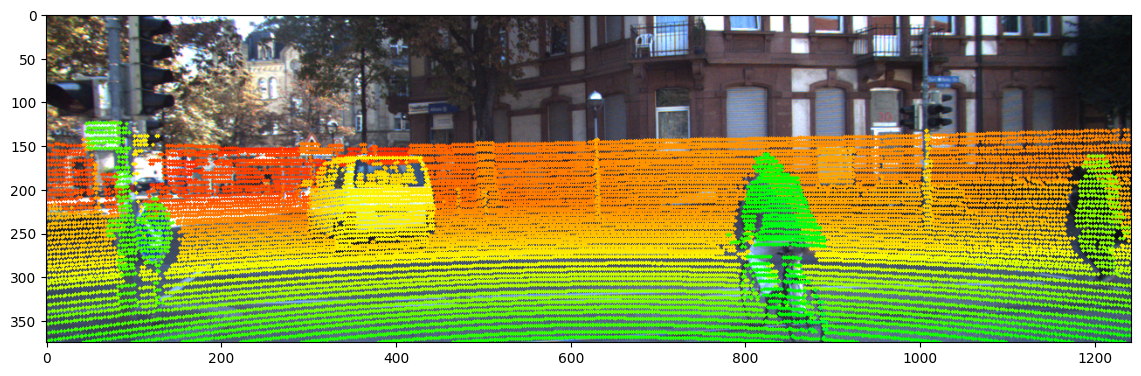

In [19]:
#img_3 = lidar2cam.show_lidar_on_image(points[:,:3], image)
img_3 = image.copy()
img_3 = lidar2cam.show_lidar_on_image(points[:,:3], img_3)
plt.figure(figsize=(14,7))
plt.imshow(img_3)
plt.show()

#### 2 - Objekterkennung in 2D

In [20]:
!python3 -m pip install Yolov4==2.0.2 # After Checking, YOLO 2.0.2 works without modifying anything. Otherwise keep 1.2.1

  Preparing metadata (setup.py) ... done
  Created wheel for Yolov4: filename=yolov4-2.0.2-py3-none-any.whl size=39739 sha256=f79f0e84682b399c0f9a3a8b093ff266aecd2d1abae49d1436802149d32ad02b
  Stored in directory: /root/.cache/pip/wheels/55/32/e0/b3cc98a6ab4a0a583ce2572baf44ef09172ed74e61dbfddc26
Successfully built Yolov4


1/1 [==============================] - 5s 5s/step


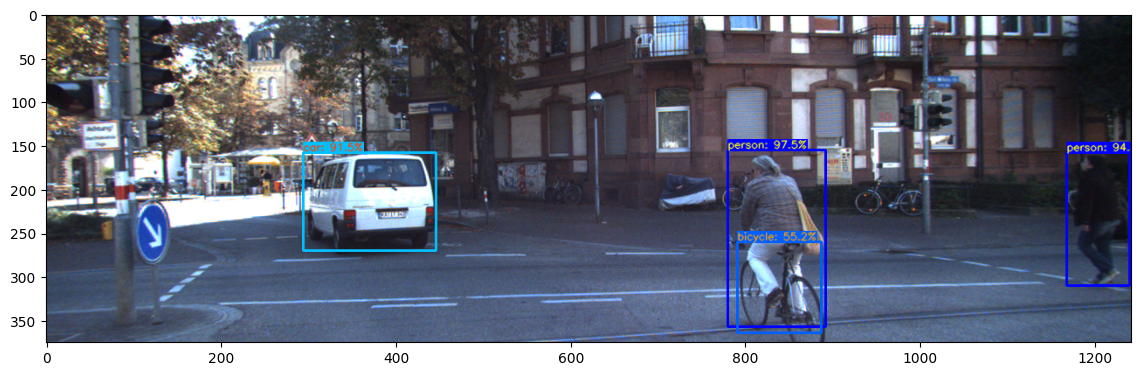

In [21]:
import numpy as np
from yolov4.tf import YOLOv4
import tensorflow as tf
import time

yolo = YOLOv4(tiny=True)
yolo.classes = "Yolov4/coco.names"
yolo.make_model()
yolo.load_weights("Yolov4/yolov4-tiny.weights", weights_type="yolo")

def run_obstacle_detection(img):
    start_time=time.time()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = yolo.resize_image(img)
    # 0 ~ 255 to 0.0 ~ 1.0
    resized_image = resized_image / 255.
    #input_data == Dim(1, input_size, input_size, channels)
    input_data = resized_image[np.newaxis, ...].astype(np.float32)
    candidates = yolo.model.predict(input_data)
    _candidates = []
    result = img.copy()

    for candidate in candidates:
            batch_size = candidate.shape[0]
            grid_size = candidate.shape[1]
            _candidates.append(tf.reshape(candidate, shape=(1, grid_size * grid_size * 3, -1)))
            #candidates == Dim(batch, candidates, (bbox))
            candidates = np.concatenate(_candidates, axis=1)
            #pred_bboxes == Dim(candidates, (x, y, w, h, class_id, prob))
            pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0], iou_threshold=0.35, score_threshold=0.40)
            pred_bboxes = pred_bboxes[~(pred_bboxes==0).all(1)] #https://stackoverflow.com/questions/35673095/python-how-to-eliminate-all-the-zero-rows-from-a-matrix-in-numpy?lq=1
            pred_bboxes = yolo.fit_pred_bboxes_to_original(pred_bboxes, img.shape)
            exec_time = time.time() - start_time
            #print("time: {:.2f} ms".format(exec_time * 1000))
            result = yolo.draw_bboxes(img, pred_bboxes)
            result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result, pred_bboxes

result, pred_bboxes = run_obstacle_detection(image)
fig_camera = plt.figure(figsize=(14, 7))
ax_lidar = fig_camera.subplots()
ax_lidar.imshow(result)
plt.show()


#### 3 - Fusion von Punktwolken und Bounding Boxes

In [ ]:
lidar_img_with_bboxes= yolo.draw_bboxes(img_3, pred_bboxes)
fig_fusion = plt.figure(figsize=(14, 7))
ax_fusion = fig_fusion.subplots()
ax_fusion.imshow(lidar_img_with_bboxes)
plt.show()
cv2.imwrite("output/lidar_bboxes.png", lidar_img_with_bboxes)

In [ ]:
print(pred_bboxes)

In [ ]:
def rectContains(rect,pt, w, h, shrink_factor = 0):
    x1 = int(rect[0]*w - rect[2]*w*0.5*(1-shrink_factor)) # center_x - width /2 * shrink_factor
    y1 = int(rect[1]*h-rect[3]*h*0.5*(1-shrink_factor)) # center_y - height /2 * shrink_factor
    x2 = int(rect[0]*w + rect[2]*w*0.5*(1-shrink_factor)) # center_x + width/2 * shrink_factor
    y2 = int(rect[1]*h+rect[3]*h*0.5*(1-shrink_factor)) # center_y + height/2 * shrink_factor

    return x1 < pt[0]<x2 and y1 <pt[1]<y2

In [ ]:
import statistics
import random

def filter_outliers(distances):
    inliers = []
    mu  = statistics.mean(distances)
    std = statistics.stdev(distances)
    for x in distances:
        if abs(x-mu) < std:
            # This is an INLIER
            inliers.append(x)
    return inliers

def get_best_distance(distances, technique="closest"):
    if technique == "closest":
        return min(distances)
    elif technique =="average":
        return statistics.mean(distances)
    elif technique == "random":
        return random.choice(distances)
    else:
        return statistics.median(sorted(distances))

In [ ]:
def lidar_camera_fusion(self, pred_bboxes, image):
    img_bis = image.copy()

    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    distances = []
    for box in pred_bboxes:
        distances = []
        for i in range(self.imgfov_pts_2d.shape[0]):
            #depth = self.imgfov_pc_rect[i, 2]
            depth = self.imgfov_pc_velo[i,0]
            if (rectContains(box, self.imgfov_pts_2d[i], image.shape[1], image.shape[0], shrink_factor=0.2)==True):
                distances.append(depth)

                color = cmap[int(510.0 / depth), :]
                cv2.circle(img_bis,(int(np.round(self.imgfov_pts_2d[i, 0])), int(np.round(self.imgfov_pts_2d[i, 1]))),2,color=tuple(color),thickness=-1,)
        h, w, _ = img_bis.shape
        if (len(distances)>2):
            distances = filter_outliers(distances)
            best_distance = get_best_distance(distances, technique="average")
            cv2.putText(img_bis, '{0:.2f} m'.format(best_distance), (int(box[0]*w),int(box[1]*h)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 3, cv2.LINE_AA)
        distances_to_keep = []

    return img_bis, distances

LiDAR2Camera.lidar_camera_fusion = lidar_camera_fusion

In [ ]:
final_result, _ = lidar2cam.lidar_camera_fusion(pred_bboxes, result)

fig_keeping = plt.figure(figsize=(14, 7))
ax_keeping = fig_keeping.subplots()
ax_keeping.imshow(final_result)
plt.show()

#### Eine Pipeline erstellen

In [ ]:
def pipeline (self, image, point_cloud):
    "For a pair of 2 Calibrated Images"
    img = image.copy()
    # Show LidAR on Image
    lidar_img = self.show_lidar_on_image(point_cloud[:,:3], image)
    # Run obstacle detection in 2D
    result, pred_bboxes = run_obstacle_detection(img)
    # Fuse Point Clouds & Bounding Boxes
    img_final, _ = self.lidar_camera_fusion(pred_bboxes, result)
    return img_final

LiDAR2Camera.pipeline = pipeline

In [ ]:
image_files = sorted(glob.glob("data/video2/images/*.png"))
point_files = sorted(glob.glob("data/video2/points/*.pcd"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

lidar2cam = LiDAR2Camera(calib_files[index])
cloud = o3d.io.read_point_cloud(pcd_file)
points= np.asarray(cloud.points)

index = 0
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14,7))
final_result = lidar2cam.pipeline(image.copy(), points)
plt.imshow(final_result)
plt.show()

#### Ein Video erstellen

In [ ]:
video_images = sorted(glob.glob("data/video2/images/*.png"))
video_points = sorted(glob.glob("data/video2/points/*.pcd"))

# Build a LiDAR2Cam object
lidar2cam_video = LiDAR2Camera(calib_files[0])

result_video = []

for idx, img in enumerate(video_images):
     image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
     point_cloud = np.asarray(o3d.io.read_point_cloud(video_points[idx]).points)
     result_video.append(lidar2cam_video.pipeline(image, point_cloud))

In [ ]:
import os

os.mkdir('output')

# out = cv2.VideoWriter('output/video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (image.shape[1],image.shape[0]))}
out = cv2.VideoWriter('output/video.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (image.shape[1],image.shape[0]))

for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
    #out.write(result_video[i])
out.release()